In [ ]:
from importlib import reload

import numpy as np
from matplotlib import pyplot as plt
import jax
from jax import numpy as jnp
jax.config.update("jax_enable_x64", True)

import simultaneous
reload(simultaneous)

jndarray = jnp.ndarray

In [ ]:
def get_initial_values(system):
    SEED = 42

    I, J, J_sim = system.I, system.J, system.J_sim

    # Initial true state
    init = np.random.default_rng(SEED).uniform(size=I + I * J)

    u0 = jnp.array(init[:I])
    v0 = jnp.array(jnp.reshape(init[I:], (I, J)))

    # Initial simulation state
    u0_sim = jnp.zeros_like(u0)
    v0_sim = jnp.zeros((I, J_sim))

    return u0, v0, u0_sim, v0_sim


def simulate(system, solver, dt, T0, Tf, t_relax):
    t0 = T0
    tf = t0 + t_relax
    u0, v0, u0_sim, v0_sim = get_initial_values(system)

    c1s = [system.c1]
    c2s = [system.c2]

    u_errors = []
    v_errors = []

    while tf <= Tf:
        U, V, Un, Vn = solver.solve(system, u0, v0, u0_sim, v0_sim, t0, tf, dt)

        u0, v0, u0_sim, v0_sim = U[-1], V[-1], Un[-1], Vn[-1]

        # Update parameters
        c1, c2 = simultaneous.levenberg_marquardt(system, u0, u0_sim, v0_sim)
        c1s.append(c1.item())
        c2s.append(c2.item())
        system.c1 = c1s[-1]
        system.c2 = c2s[-1]

        t0 = tf
        tf = t0 + t_relax

        # Relative error
        u_errors.append(
            np.linalg.norm(U - Un, axis=1) / np.linalg.norm(U, axis=1)
        )
        v_errors.append(
            np.linalg.norm(V - Vn, axis=(1, 2)) / np.linalg.norm(V, axis=(1, 2))
        )

    u_errors = np.concatenate(u_errors)
    v_errors = np.concatenate(v_errors)

    # Note `t0` is the actual final time of the simulation (Tf_actual).
    tls = np.linspace(T0, t0, len(u_errors) + 1)

    return c1s, c2s, u_errors, v_errors, tls


def plot(c1s, c2s, u_errors, v_errors, γ1, γ2, tls):
    num_iters = len(c1s)
    ils = np.arange(num_iters)

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    ax = axs[0, 0]
    ax.hlines(γ1, ils[0], ils[-1], label="γ1", color="black")
    ax.plot(ils, c1s, label="c1")
    ax.legend()
    ax.set_title("c1 vs γ1")
    ax.set_xlabel("Iteration number")

    ax = axs[0, 1]
    ax.hlines(γ2, ils[0], ils[-1], label="γ2", color="black")
    ax.plot(ils, c2s, label="c2")
    ax.legend()
    ax.set_title("c2 vs γ2")
    ax.set_xlabel("Iteration number")

    ax = axs[1, 0]
    ax.plot(tls[1:], u_errors)
    ax.set_yscale("log")
    ax.set_title("Relative error in $u$")
    ax.set_xlabel("Time")

    ax = axs[1, 1]
    ax.plot(tls[1:], v_errors)
    ax.set_yscale("log")
    ax.set_title("Relative error in $v$")
    ax.set_xlabel("Time")

    fig.tight_layout()

    return fig, axs

In [ ]:
# Dimensions
I, J = 40, 5
J_sim = J

# System evolution parameters
γ1, γ2 = 1e-2, 0.5
c1, c2 = γ1, γ2
c1 *= 0.5
c2 *= 0.5
ds = jnp.array([0.2, 0.5, 1, 2, 5])
F = 8
μ = 50

system = simultaneous.System(I, J, J_sim, γ1, γ2, c1, c2, ds, F, μ)
solver = simultaneous.RK4(system)

# Simulation parameters
dt = 0.04
T0, Tf = 0, 2000
t_relax = 1

c1s, c2s, u_errors, v_errors, tls = simulate(
    system, solver, dt, T0, Tf, t_relax
)

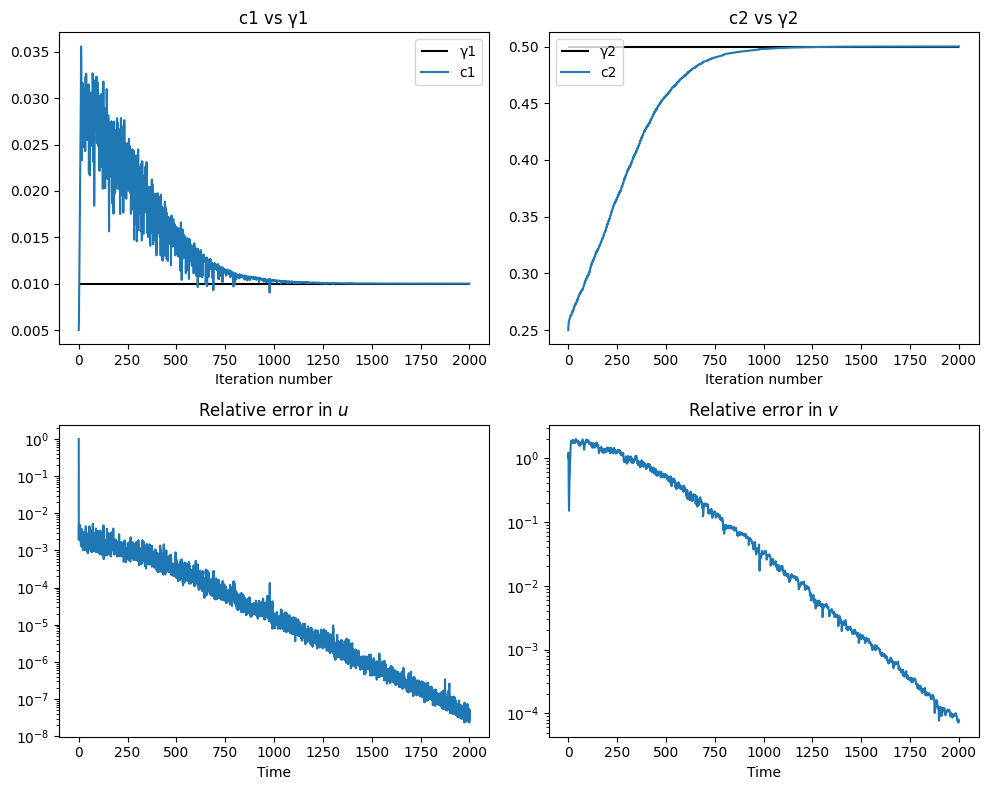

In [ ]:
fig, axs = plot(c1s, c2s, u_errors, v_errors, γ1, γ2, tls)
plt.show()